# Conditional GAN Validator (MNIST)
### O. Osoba
### Date: Jan2019
Verify that a conditional GAN implementation performs adequately/minimally. <br>
Basic test vaidating GC class

References:
- [Original GAN Paper](https://arxiv.org/pdf/1406.2661.pdf).
- [MNIST Dataset](http://yann.lecun.com/exdb/mnist/).

In [1]:
import sys, importlib

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("./lib")

In [2]:
# ML libs
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
import gan_classed as GC
print("GAN-Classed Lib version:", GC.__version__)

%pylab inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (7,7)

Tensorflow version: 1.13.1
GAN-Classed Lib version: 0.0.3
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Import MNIST data: Keras load since base-tf deprecated
mnist = tf.keras.datasets.mnist.load_data()
# mnist structure: (x_train, y_train), (x_test, y_test); images unnormalized

# from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets("../ML-Examples/MNIST/", one_hot=True)
# (mnist.train.next_batch(1))[0].shape

In [3]:
ns = len(mnist[0][0]) #3*int(10**4)
mdata = (mnist[0][0][:ns].reshape((ns,-1)))/255.0
cinds = mnist[0][1][:ns]

#plt.imshow(mdata[0,:].reshape([28, 28]))
#print((mdata).shape, max(mdata[0,:]))

In [4]:
from sklearn.preprocessing import OneHotEncoder#, LabelEncoder
enc = OneHotEncoder(categories='auto')
enc.fit(cinds[..., None])
#print(list(zip(cinds[:10],enc.transform(cinds[:10, None]).toarray())))
cinds_n = enc.transform(cinds[:, None]).toarray()


#mdata = np.hstack((mdata, cinds[...,None]))
mdata = np.hstack((cinds_n, mdata))
print(cinds_n.shape, mdata.shape)

(60000, 10) (60000, 794)


In [5]:
# Training Params
# num_steps = 50000
# batch_size = 128
# lrs = (1e-3, 1e-4) 
# noise_dim = 3


## these params give good results on adamien model:
num_steps = 100002
batch_size = 128
learning_rate = 0.0001 # 0.0002
lrs = (1.5*learning_rate, learning_rate)
disc_hidden_dim = 384 #256
gen_hidden_dim = 384 #256
noise_dim = 50 #100

In [6]:
importlib.reload(GC)
#sess.close()
tf.reset_default_graph()

# Setup Loggers
log_path = "../log"
run_name = "mnist_1"
# tensorboard --logdir=mnist_cgan_1:'../log/train_cgan_mnist_1'

In [7]:
digitgan = GC.Conditional_GAN(
    data = mdata,
    noiseDim = noise_dim,
    indices_CvG = (list(range(10)), list(range(10,794))),
    #discSpec = (64,64), genSpec = (64,64),
    discSpec = (disc_hidden_dim,), genSpec = (gen_hidden_dim,),
    model_path = log_path,
    name = run_name,
    learning_rates = lrs
)


digitgan.dataP[:,digitgan.genInds].shape
#plt.imshow(digitgan.dataP[0,digitgan.genInds].reshape([28, 28]))
# tf.trainable_variables()

(60000, 784)

In [8]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
sv = tf.train.Saver(max_to_keep=1)

digitgan.work(sess, saver = sv, 
              num_epochs = num_steps, 
              batch_sz = batch_size)

Starting agent cgan_mnist_1
Step 0: Generator Loss: 0.644831, Discriminator Loss: 1.390071
Saved Model
Step 10000: Generator Loss: 1.592633, Discriminator Loss: 0.671074
Saved Model
Step 20000: Generator Loss: 2.210260, Discriminator Loss: 0.389909
Saved Model
Step 30000: Generator Loss: 2.546392, Discriminator Loss: 0.364651
Saved Model
Step 40000: Generator Loss: 2.314033, Discriminator Loss: 0.560107
Saved Model
Step 50000: Generator Loss: 2.420921, Discriminator Loss: 0.358919
Saved Model
Step 60000: Generator Loss: 1.808364, Discriminator Loss: 0.621150
Saved Model
Step 70000: Generator Loss: 1.853691, Discriminator Loss: 0.702717
Saved Model
Step 80000: Generator Loss: 1.424940, Discriminator Loss: 1.118639
Saved Model
Step 90000: Generator Loss: 1.944876, Discriminator Loss: 0.701867
Saved Model
Step 100000: Generator Loss: 1.798919, Discriminator Loss: 0.595300
Saved Model


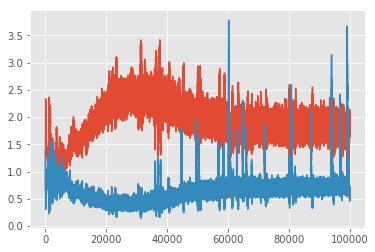

In [9]:
plt.plot(digitgan.gen_losses)
plt.plot(digitgan.disc_losses)

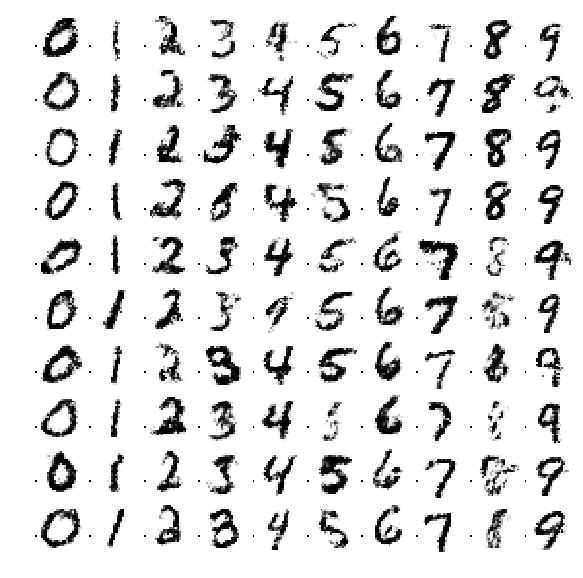

In [10]:
# Testing
# Generate images from noise, using the generator network.
n = 10
canvas = np.empty((28 * n, 28 * n))
for i in range(n):
    digs = np.arange(10, dtype=np.int32)
    digs = enc.transform(digs[:,None]).toarray()
    g = digitgan.generate(sess, digs)
    # Reverse colours for better display
    g = -1 * (g - 1)
    for j in range(n):
        # Draw the generated digits
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.axis('off')
plt.show()

## Troubleshooting

In [11]:
# sess = tf.Session()
# sess.run(tf.global_variables_initializer())

In [12]:
# sess.run([digitgan.disc_fake, digitgan.disc_real, digitgan.disc_loss],
#         feed_dict={
#             digitgan.class_input: cinds_n[:10,:],
#             digitgan.d_input: digitgan.dataP[:10, digitgan.genInds],
#             digitgan.n_input: np.random.uniform(-1., 1.,size=[10, noise_dim])
#         })